# Practical 5 - Dimensionality Reduction with PCA and t-SNE

Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, June 27, 2pm

In this practical we will implement dimensionality reduction with PCA, followed by t-SNE. Following is going to be the outline:

 1. Imports
 2. Loading data and related transformations 
 3. PCA without sklearn 
 4. PCA with sklearn and comparison with 3. 
 5. t-SNE with sklearn 

You will be plotting relevant results for viusalization and understanding as you go through the objectives. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='talk',style='white',palette='colorblind')
import pickle
import matplotlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy as sp
print("fertig")

fertig


## Task 0: Load and normalize count data

This practical uses the data set from https://www.nature.com/articles/s41586-018-0654-5. This is single cell transcriptomics data from ~25,000 cells from the cortex. 

For each of these cells, the expression of several thousand genes was measured ```['counts']```. In the original study, the authors were interested in clustering the cells into types. In the context of single-cell transcriptomics data, gene expression levels refer to the measured quantities of RNA molecules (mRNA) derived from specific genes within individual cells. These measurements provide information about the activity and relative abundance of different genes in each cell. 

We made a selection of 5000 cells and the 1000 most informative genes for run time reasons. We provide you with the original cell type labels determined by the authors for comparison ```['clusters']```.

The following function will apply some preprocessing steps that are standard for transcriptomics data. We normalize the data to bring columns to comparable sizes and log-transform them as they contain huge outliers.

In [3]:
def lognormalize_counts(tasic_dict):

    # normalize and logtransform counts
    counts = tasic_dict['counts']
    libsizes = counts.sum(axis=1) # sum of counts over row/cell.
    CPM = counts / libsizes * 1e+6
    logCPM = np.log2(CPM + 1)
    tasic_dict['logCPM'] = np.array(logCPM)

    return tasic_dict


The variable CPM most likely stands for "Counts Per Million" and is a measure used in transcriptomics data analysis to normalize gene expression levels across samples. It is a common normalization method to account for differences in library sizes or sequencing depths between samples.

The calculation of CPM involves the following steps:

Count the number of raw counts (gene expression counts) for each gene in a given sample.
Sum up the counts for all genes in that sample to obtain the library size (total counts).
Divide each gene's count by the library size.
Multiply the result by a scaling factor, typically 1 million, to obtain the Counts Per Million value for each gene.
By normalizing the gene expression levels to a common scale (per million counts), the CPM measure allows for more accurate comparisons of gene expression levels between samples. This normalization accounts for differences in library sizes, ensuring that the comparisons are not biased by variations in sequencing depth or total counts.

In the code snippet you provided, the variable CPM is calculated by dividing the counts by the library sizes (libsizes) and then multiplying by 1 million. It represents the normalized gene expression levels in Counts Per Million for each gene in the transcriptomics data.

In [4]:
#data = pickle.load(open('data/tasic_subset_1kselected.pickle', 'rb'))

In [5]:
#print(data)

In [38]:
#counts = data['counts']
#counts
    # rows: 5000 cells
    # columns: 1000 most important genes
    # cell: gene expression level

<5000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 937979 stored elements in Compressed Sparse Column format>

In [6]:
#len(data['genes']) # column labels

In [61]:
## Assuming your sparse matrix is named 'matrix'
#first_rows = counts[:10]  # Get the first 5 rows
#
## Convert the sparse matrix to a dense array for printing
#dense_matrix = first_rows.toarray()
#
## Print the dense array representation
#np.set_printoptions(edgeitems=4)
#print(dense_matrix)

[[   0.    0.    0.    0. ...    0.    0.    0. 5320.]
 [   0.    0.    0.    0. ...    0.    0.    0. 3147.]
 [   0.    0.    0.    0. ...    0.    0.    0. 4828.]
 [   0.    0.    0.    0. ...    0.    0.    0. 3440.]
 ...
 [   0.    0.    0.    0. ...    0.    0.    0. 5392.]
 [   0.    0.    0.    0. ...    0.    0.    0. 3281.]
 [   0.    0.    0.    0. ...    0.    0.    0. 2945.]
 [   0.    0.    0.    0. ...    0.    0.    0. 3388.]]


In [45]:
#print(first_rows)

In [24]:
#len(tasic_1k['clusters']) => vector of length 5000 which shows to which cluster a cell corresponds (original labels)
# There are 133 clusters
# print(np.unique(tasic_1k['clusters']))

In [7]:
tasic_1k = lognormalize_counts(pickle.load(open('data/tasic_subset_1kselected.pickle', 'rb')))

C:\Users\Work\AppData\Local\Temp\ipykernel_19584\4263010647.py:1: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  tasic_1k = lognormalize_counts(pickle.load(open('data/tasic_subset_1kselected.pickle', 'rb')))


Have a look at ```['counts']```, ```['logPCM']``` and ```['clusters']``` to get a better understanding of the data. Plot a histogram of the cell type labels provided by  ```['clusters']```.

In [18]:
# Explore data
    #np.set_printoptions(edgeitems=3)
np.set_printoptions(None)
print("Counts:")
print(f"{tasic_1k['counts'].toarray()}\n")

print("logCPM:")
print(f"{tasic_1k['logCPM']}\n")

print("Clusters:")
print(f"{tasic_1k['clusters']}")

Counts:
[[0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 5.320e+03]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 3.147e+03]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 4.828e+03]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 2.923e+03 1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]

logCPM:
[[ 0.          0.          0.         ...  0.          0.
  14.48400138]
 [ 0.          0.          0.         ...  0.          0.
  14.74268238]
 [ 0.          0.          0.         ...  0.          0.
  14.86580424]
 ...
 [ 0.          0.          0.         ...  0.         14.08885484
   2.79928049]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]

Clusters:
[ 93  72   1 ... 127 127 127]


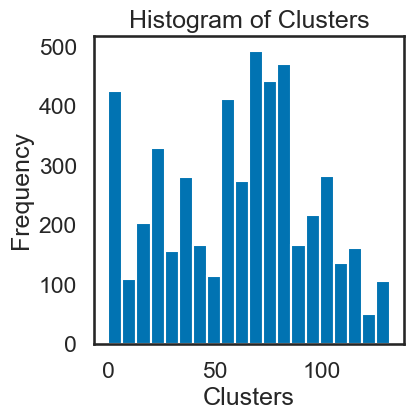

In [40]:
# Plotting
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(tasic_1k['clusters'], bins = 20)
ax.set_xlabel('Clusters')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Clusters')
plt.show()

## Task 1: Linear dimensionality reduction with PCA

In this task, you will use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset.

First, implement PCA "by hand". You can use eigenvalue/singular value decomposition from numpy/scipy but no `sklearn`-functions. Write a function that computes all possible principal components and returns them along with the fraction of variance they explain.

In [41]:
def PCA_manual(data):
    '''
    Function that performs PCA on the input data

    input: (cells, genes)-shaped array of log transformed cell counts; i.e. tasic_1k['logCPM']
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes, genes)-shaped array containing the principal components as columns
    '''
    ### NOTE: Make sure the function returns the PCs sorted by the fraction of variance explained! ###
    ###       (First column of principal_components should hold the PC with the highest variance   ###
    ###       explained -- fraction_variance_explained should also be sorted accordingly)          ###
    ###       Also remember to center your columns by substracting the mean of each column before  ###
    ###       you calculate the covariance matrix to get the principal components.                 ###

    # ---------------- INSERT CODE ----------------------
    # Center the data by subtracting the mean of each column
    centered_data = data - np.mean(data, axis=0)

    # Calculate the covariance matrix
    cov_matrix = np.cov(centered_data, rowvar=False)

    # Perform eigenvalue decomposition on the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort eigenvalues and eigenvectors in descending order of eigenvalues
    sort_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sort_indices]
    eigenvectors = eigenvectors[:, sort_indices]

    # Compute the fraction of variance explained by each PC
    fraction_variance_explained = eigenvalues / np.sum(eigenvalues)

    # Compute the principal components
    principal_components = eigenvectors

    

    # ---------------- END CODE -------------------------

    return fraction_variance_explained, principal_components

In [42]:
var_expl, PCs = PCA_manual(tasic_1k['logCPM'])

Eigenvectors and eigenvalues are directly related to principal components in the context of Principal Component Analysis (PCA).

In PCA, the eigenvectors represent the directions or axes in the original feature space along which the data vary the most. These eigenvectors are also known as the principal components. Each eigenvector corresponds to a principal component.

The eigenvalues associated with the eigenvectors represent the amount of variance explained by each principal component. Larger eigenvalues indicate that the corresponding principal components capture more of the variability in the data.

During the PCA process, the eigenvectors are computed by decomposing the covariance matrix of the data. The covariance matrix represents the relationships and variability between the different variables (features) in the data. The eigenvectors of the covariance matrix are the directions in which the data vary the most.

The eigenvalues associated with the eigenvectors indicate the amount of variance explained by each eigenvector or principal component. The eigenvalues are proportional to the squared lengths of the corresponding eigenvectors. Larger eigenvalues indicate that the corresponding principal components explain more of the variability in the data.

Therefore, in PCA, the eigenvectors represent the principal components or the directions of maximum variability in the data, while the eigenvalues represent the amount of variance explained by each principal component.

PCA leads to dimensionality reduction by selecting a subset of the principal components that capture the most significant variability in the data. The idea is to retain the principal components that explain the majority of the variance while discarding those with relatively smaller variances.

In PCA, the principal components are ordered based on the amount of variance they explain, with the first principal component explaining the highest variance, the second principal component explaining the second highest variance, and so on. By selecting a subset of the principal components, we can effectively reduce the dimensionality of the data.

Since the principal components represent the directions of maximum variability in the data, the retained principal components can capture the most salient patterns and structure present in the original high-dimensional data. By discarding the principal components with lower variances, which may correspond to noise or less informative dimensions, we can reduce the dimensionality of the data while preserving the most important information.

The reduced-dimensional representation is obtained by projecting the original data onto the selected principal components. This projection effectively transforms the data from the original high-dimensional space to a lower-dimensional space spanned by the retained principal components. The resulting reduced-dimensional representation retains most of the variability and relevant patterns in the data, while discarding the redundant or less informative dimensions.

In summary, PCA achieves dimensionality reduction by selecting a subset of the principal components that explain the most variance, thus capturing the essential information in a lower-dimensional space.

Before we explore the structure of the low-dimensional representation, we first want to know how much variance the first PCs explain: 

- Plot the fraction of variance explained by the `n`-th PC vs. `n`

- Plot the cumulative fraction of variance explained by the first `n` PCs with largest eigenvalue vs. `n`

From the latter plot you should be able to see how many PCs you need to keep to explain at least `x`% of the variance.

How many components do you need to keep to explain 50%, 75%, 90% and 99%, respectively? Indicate this in your plot.

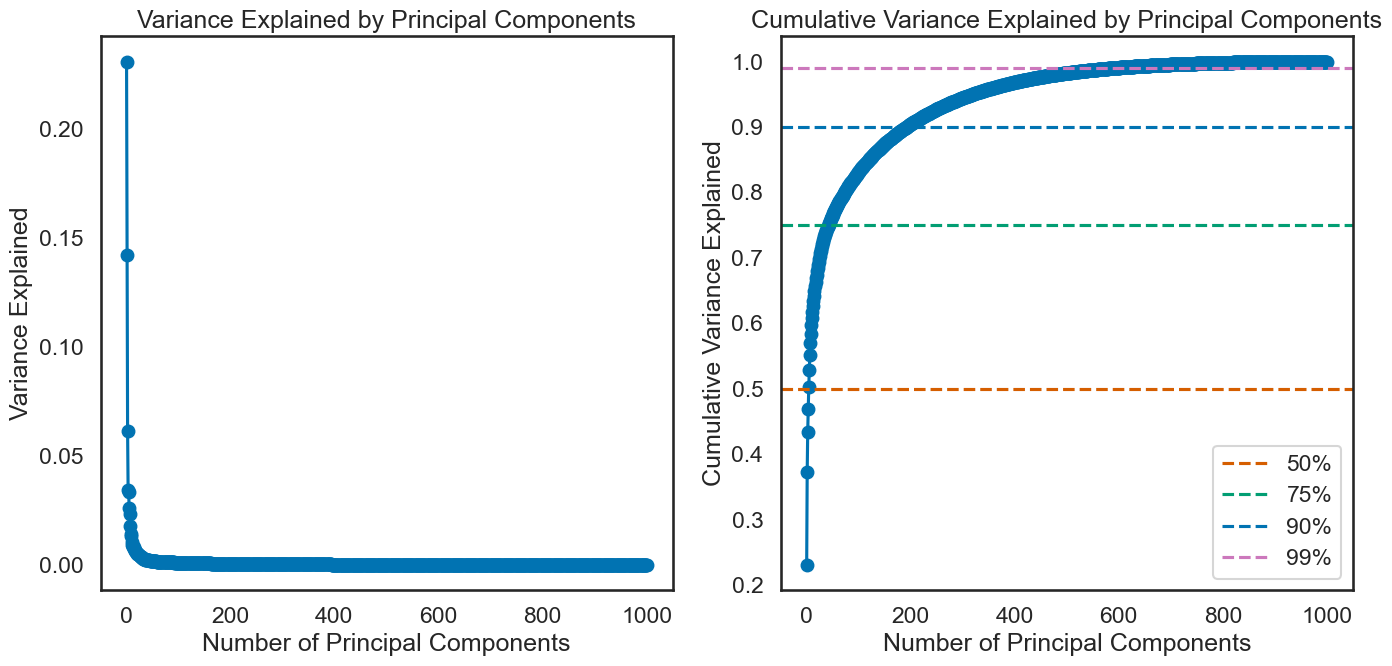

In [46]:
n_PCs = len(var_expl)
PC_ids = np.arange(1, n_PCs+1)

plt.figure(figsize=(14, 7))

plt.subplot(121)

# Plot the variance explained of the n-th PC vs. n
# ---------------- INSERT CODE ----------------------
plt.plot(PC_ids, var_expl, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')


# ---------------- END CODE -------------------------

plt.subplot(122)

# Plot the cumulative variance explained for the n PCs with highest variance explained vs. n
# Indicate how many components you need to keep to explain 50%, 75%, 90% and 99% in the plot.

# ---------------- INSERT CODE ----------------------
cumulative_var_expl = np.cumsum(var_expl)
plt.plot(PC_ids, cumulative_var_expl, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
# ---------------- END CODE -------------------------

plt.axhline(y=0.5, color='r', linestyle='--', label='50%')
plt.axhline(y=0.75, color='g', linestyle='--', label='75%')
plt.axhline(y=0.9, color='b', linestyle='--', label='90%')
plt.axhline(y=0.99, color='m', linestyle='--', label='99%')

plt.legend()

plt.tight_layout()
plt.show()

In [47]:
cumulative_thresholds = [0.5, 0.75, 0.9, 0.99]  # Cumulative percentage thresholds
n_components_needed = []

for threshold in cumulative_thresholds:
    n_components_needed.append(np.argmax(cumulative_var_expl >= threshold) + 1)

print("Number of components needed to explain:")
for i, threshold in enumerate(cumulative_thresholds):
    print(f"{int(threshold*100)}%: {n_components_needed[i]}")


Number of components needed to explain:
50%: 5
75%: 43
90%: 193
99%: 590


YOUR ANSWER HERE

Write a function to select the `n` PCs needed to explain at least `x`% of the variance and use this function to extract as many PCs as are needed to explain 75% of the variance. 

In [48]:
def select_PCs(variance_explained, principal_components, percent_variance=None):
    '''Function that selects the first n principal components necessary to explain x% of the variance
    input:
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain
    output:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes,n_PCs_kept)
    '''

    if percent_variance is not None:
        # Calculate the cumulative variance explained
        cumulative_var_expl = np.cumsum(variance_explained)

        # Find the index of the first element greater than or equal to the specified percentage
        n_components = np.argmax(cumulative_var_expl >= percent_variance) + 1

        # Select the first n principal components
        variance_explained_kept = variance_explained[:n_components]
        principal_components_kept = principal_components[:, :n_components]
    else:
        variance_explained_kept = variance_explained
        principal_components_kept = principal_components

    return variance_explained_kept, principal_components_kept


In [50]:
_, PCs75 = select_PCs(var_expl, PCs, percent_variance=0.75)

To compute the representation of the data in this lower dimensional representation, write a function that compute the PC scores for each cell, i.e. that projects the original data matrix on the low-dimensional subspace provided by the first `n` PCs:

In [51]:
def compute_PCA_scores(data, principal_components):
    '''Function that returns the PC scores for each data point
    input:
        data                 --- (cells, genes)-shaped array of log transformed cell counts
        principal_components --- contains the principal components as columns
    output:
        pc_scores            --- (cells, n_PCs_kept)-shaped array of PC scores
    '''

    # Center the data by subtracting the column means
    centered_data = data - np.mean(data, axis=0)

    # Calculate the PC scores by projecting the centered data onto the principal components
    pc_scores = np.dot(centered_data, principal_components)

    return pc_scores


In [52]:
tasic_1k['PCA_75'] = compute_PCA_scores(tasic_1k['logCPM'], PCs75)

Visualize the top 5 PCs as a pairwise scatterplot. Use one subplot for each pair of components.

Use the colors provided in `tasic_1k['clusterColors']` and the cluster information in `tasic_1k['clusters']` to color each data point according to its original cluster identity.

The colors indicate the family of the cell type:

- greenish colors: excitatory neurons
- orange colors: somatostatin positive interneurons
- pinkish colors: VIP-postive interneurons
- reddish colors: parvalbumin positive interneurons
- dark colors: non-neurons (glia etc)

What do you observe?

In [54]:
# First try. does not really work. WIP
def plot_PCs(data_transformed, color_per_datapoint):
    '''Function that plots the scores of the 10 pairs of the top 5 PCs against each other.
        inputs:
            data_transformed    -- (cells, n_PCs_kept)-shaped array of PC scores
            color_per_datapoint -- (cells,)-shaped array of color strings, one color for each cell
    '''

    n_PCs = data_transformed.shape[1]
    n_subplot_rows = int(n_PCs * (n_PCs - 1) / 2)  # Calculate the number of subplot rows

    # Create a figure and subplots with the appropriate number of rows and columns
    fig, axes = plt.subplots(n_subplot_rows, 1, figsize=(10, 10 * n_subplot_rows))

    # Iterate over pairs of principal components
    subplot_index = 0
    for i in range(n_PCs - 1):
        for j in range(i + 1, n_PCs):
            # Get the PC scores for the pair of components
            x = data_transformed[:, i]
            y = data_transformed[:, j]

            # Create a scatter plot with colors based on cluster identity
            ax = axes[subplot_index]
            ax.scatter(x, y, c=color_per_datapoint, alpha=0.8)
            ax.set_xlabel(f'PC{i+1}')
            ax.set_ylabel(f'PC{j+1}')
            ax.set_title(f'PC{i+1} vs PC{j+1}')

            subplot_index += 1

    plt.tight_layout()
    plt.show()

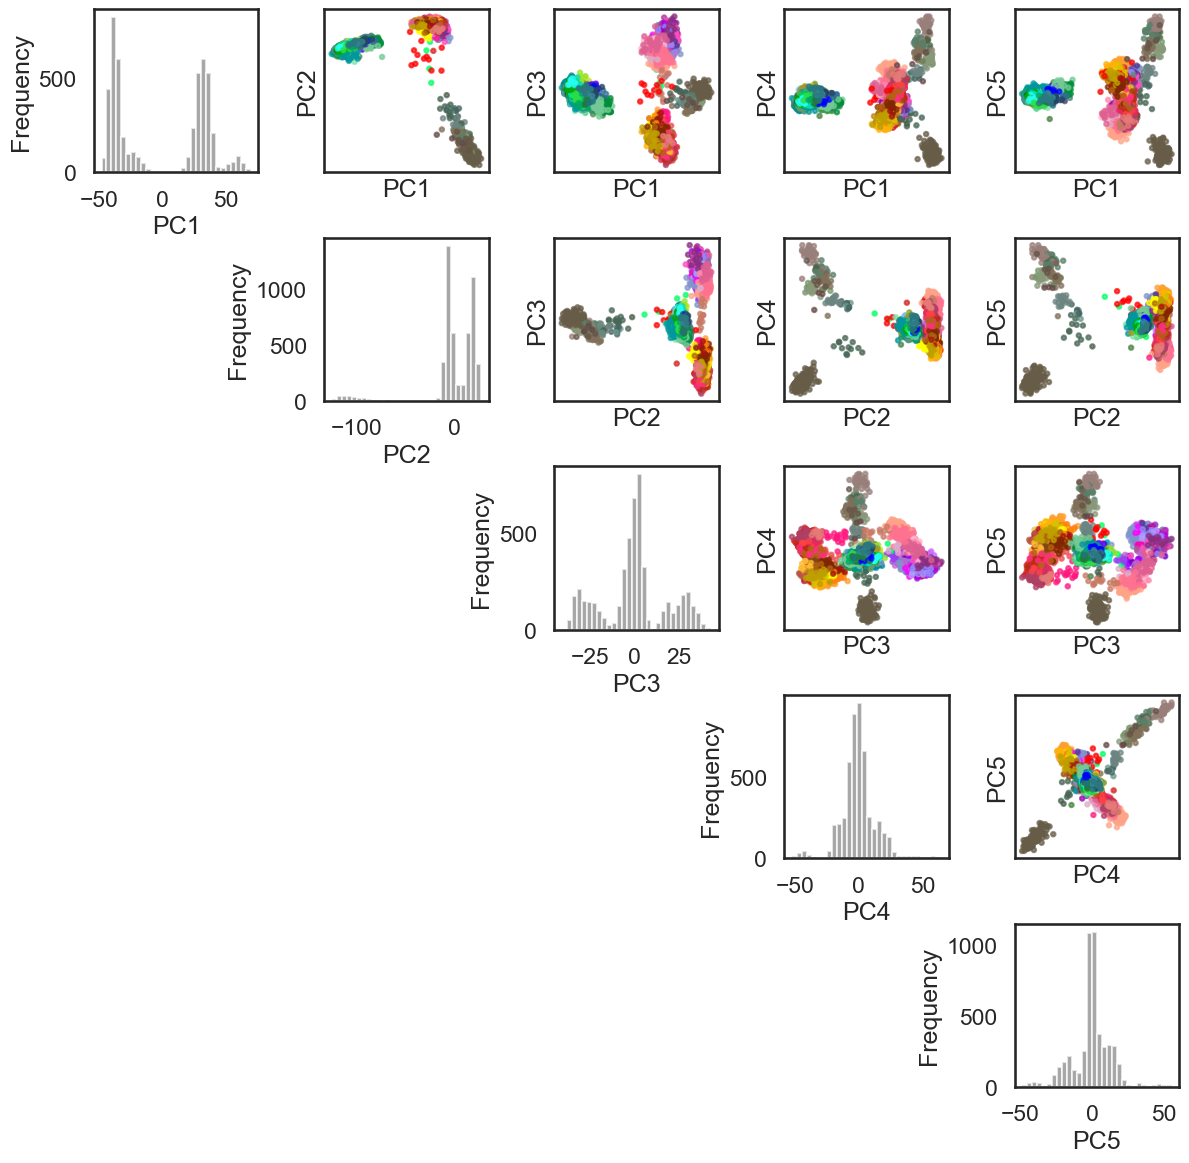

In [57]:
def plot_PCs(data_transformed, color_per_datapoint):
    '''Function that plots the scores of the 10 pairs of the top 5 PCs against each other.
        inputs:
            data_transformed    -- (cells, n_PCs_kept)-shaped array of PC scores
            color_per_datapoint -- (cells,)-shaped array of color strings, one color for each cell
    '''

    # ---------------- INSERT CODE ----------------------
    top_n_PCs = 5
    fig, axes = plt.subplots(nrows=top_n_PCs, ncols=top_n_PCs, figsize=(14, 14))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    for i in range(top_n_PCs):
        for j in range(top_n_PCs):
            ax = axes[i, j]

            if i == j:
                ax.hist(data_transformed[:, i], color='gray', bins=30, alpha=0.7)
                ax.set_xlabel(f'PC{i+1}')
                ax.set_ylabel('Frequency')
            elif j > i:
                ax.scatter(data_transformed[:, i], data_transformed[:, j], c=color_per_datapoint, alpha=0.7, s=10)
                ax.set_xlabel(f'PC{i+1}')
                ax.set_ylabel(f'PC{j+1}')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.axis('off')

    plt.show()
    # ---------------- END CODE -------------------------

In [ ]:
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
plot_PCs(tasic_1k['PCA_75'], color_per_datapoint)

YOUR ANSWER HERE

## Task 2: Comparison with PCA implemented by sklearn

Use the PCA implementation of sklearn to check whether your PCA implementation is correct and obtain some insights into numerical precision of the algorithms underlying PCA implementations. Note that the sklearn implementation of PCA switches the dimensions of the matrix, so you will have to transpose your principal components matrix to get the same output as in the manual implementation.

In [ ]:
def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn

    input: (cells, genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes, genes)-shaped array containing the principal components as columns
    '''

    # ---------------- INSERT CODE ----------------------

    
    
    # ---------------- END CODE -------------------------

    return fraction_variance_explained, principal_components

In [ ]:
# do sklearn-PCA on selected genes
var_expl_sklearn, PCs_sklearn = PCA_sklearn(tasic_1k['logCPM'])
# select components as before
_, PCs_sklearn75 = select_PCs(var_expl_sklearn, PCs_sklearn, 0.75)
# get PC scores
PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'], PCs_sklearn75)

To see if your manual PCA yielded the same PC weights as the sklearn PCA, we can just take the two matrices of principal components and plot their entries against each other. (Note: This again assumes they are sorted by variance explained and the order of dimensions in your weight matrix compared to the sklearn weight matrix is the same (change if necessary).)

Use the following plot to compare the results to your own implementation (here plotting the weights of the first 100 PCs against each other). What do you observe?

In [ ]:
n_evs_to_compare = 100

plt.figure(figsize=(10, 5))
plt.scatter(PCs_sklearn[:, :n_evs_to_compare].flatten(),
            PCs[:, :n_evs_to_compare].flatten(), s=5, alpha=0.1)
plt.plot([-.7, .7], [-.7, .7], ':', c='tab:gray', label='same sign', alpha=0.3)
plt.plot([-.7, .7], [.7, -.7], '--', c='tab:gray', label='sign flipped', alpha=0.3)
plt.legend()
plt.xlabel('sklearn PCA weight')
plt.ylabel('manual PCA weight')
plt.title('Weights of the first %u manual PCs against the sklearn ones' % (n_evs_to_compare))

sns.despine()

YOUR ANSWER HERE

Additional reading about the sign of PCs: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers

## Task 3: Nonlinear dimensionality reduction with t-SNE

In this task, you will use the nonlinear dimensionality reduction technique tSNE and look at visualizations of the data set. Plot the result of default t-SNE with the original cluster colors. For this and the following tasks, use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above.

In [ ]:
def plot_tsne(tsne_results, clusters=tasic_1k['clusters'], labels=['']):
    '''Plotting function for tsne results, creates one or multiple plots of tSNE-transformed data.
       If the clustering is the original one (default), original cluster colors will be used. Otherwise,
       colors will be a random permutation.

    input:
        tsne_results: (n, 2)-shaped array containing tSNE-transformed data or list of such arrays
                      (output of the fit_transform function of sklearn tSNE)
        clusters: (n,)-shaped array containing cluster labels or list of such arrays
        labels: optional, list of titles for the subplots
    '''

    if type(tsne_results) == list:  # make sure we can do both single and multiple plots and are flexible regarding input
        num_plots = len(tsne_results)
    else:
        num_plots = 1
        tsne_results = [tsne_results]
    if type(clusters) == list:
        num_clusters = len(clusters)
        num_plots = num_plots * num_clusters
        tsne_results = tsne_results * num_clusters
    else:
        clusters = [clusters] * num_plots

    if len(labels) == 1:
        labels = labels * num_plots

    n_clusters = len(np.unique(clusters))      # ensure a long enough color list even if we plot more than
    n_colors = len(tasic_1k['clusterColors'])  # the original number of clusters
    if n_clusters > n_colors:
        n_extra_colors = n_clusters - n_colors
        colors = np.concatenate((tasic_1k['clusterColors'], tasic_1k['clusterColors'][:n_extra_colors]))
    else:
        colors = tasic_1k['clusterColors']

    fig, ax = plt.subplots(num_plots, 1, figsize=(10, num_plots*10))
    if num_plots == 1:
        if not np.all(tasic_1k['clusters'] == clusters[0]):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors
        ax.scatter(tsne_results[0][:, 0], tsne_results[0][:, 1], s=1, color=current_colors[clusters[0]])
        ax.set_title(labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    else:
        for i in range(num_plots):
            if not np.all(tasic_1k['clusters'] == clusters[i]):
                current_colors = np.random.permutation(colors)
            else:
                current_colors = colors
            ax[i].scatter(tsne_results[i][:, 0], tsne_results[i][:, 1], s=1, color=current_colors[clusters[i]])
            ax[i].set_title(labels[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_axis_off()

Run the following cells to set the random seed/random state, run tSNE and plot the results.

In [ ]:
# fit TSNE
tsne_default = TSNE(random_state=1)
tsne_results = tsne_default.fit_transform(PCA_75_sklearn)

In [ ]:
# Plotting

original_clusters = tasic_1k['clusters']
plot_tsne(tsne_results, original_clusters, labels=['default t-SNE'])

t-SNE has one main parameter called perplexity, which trades of local and global structure. Its default value is 30. Run the tSNE with some other perplexity values (e.g. 5, 100), plot the results next to each other and explain what you observe. In particular, compare with the PCA plot above.

In [ ]:
# try different perplexities

# ---------------- INSERT CODE ----------------------



# ---------------- END CODE -------------------------

In [ ]:
# plot results

# ---------------- INSERT CODE ----------------------



# ---------------- END CODE -------------------------

YOUR ANSWER HERE

Check out https://distill.pub/2016/misread-tsne/. There's a nice tool that let's you play with t-SNE paramters and visualize the consequences.